
# Example: Time Series Model - Bouncing MNIST in NumPyro

This example illustrates how to construct an inference program based on the APGS
sampler [1] for BMNIST. The details of BMNIST can be found in the sections
6.4 and F.3 of the reference. We will use the NumPyro (default) backend for this
example.

**References**

    1. Wu, Hao, et al. Amortized population Gibbs samplers with neural
       sufficient statistics. ICML 2020.

<img src="file://../_static/bmnist.gif" align="center">


In [1]:
import argparse
from functools import partial

import coix
import flax.linen as nn
import jax
from jax import random
import jax.numpy as jnp
import numpy as np
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

from sim_utils import *

/home/aleatory/aleatory-numpyro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-29 12:44:48.089768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 12:44:48.152175: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 12:44:48.167159: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 12:44:49.205872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning:

First, let's load the moving mnist dataset.



In [34]:
# def load_dataset(*, is_training, batch_size):
#   ds = tfds.load("moving_mnist:1.0.0", split="test")
#   ds = ds.repeat()
#   if is_training:
#     ds = ds.shuffle(10 * batch_size, seed=0)
#     map_fn = lambda x: x["image_sequence"][..., :10, :, :, 0] / 255
#   else:
#     map_fn = lambda x: x["image_sequence"][..., 0] / 255
#   ds = ds.batch(batch_size)
#   ds = ds.map(map_fn)
#   return iter(tfds.as_numpy(ds))

def load_dataset(*, is_training, batch_size):
  ds = np.load("worms_train.npy")
  return iter(ds)

def get_digit_mean():
  ds, ds_info = tfds.load("mnist:3.0.1", split="train", with_info=True)
  ds = tfds.as_numpy(ds.batch(ds_info.splits["train"].num_examples))
  digit_mean = next(iter(ds))["image"].squeeze(-1).mean(axis=0)
  return digit_mean / 255

Next, we define the neural proposals for the Gibbs kernels and the neural
decoder for the generative model.



In [65]:
def sim_worms(nworms):
    duration = 0.55
    snapshots = 10
    kpoints = 6
    box_size = 64
    with numpyro.plate('nworms', nworms):
        # L = numpyro.sample('L', dist.Uniform(30, 45))
        L = numpyro.sample('L', dist.Uniform(10, 15))
        A = numpyro.sample('A', dist.Normal(1, 0.1))
        T = numpyro.sample('T', dist.Normal(0.8, 0.1))
        kw = numpyro.sample('kw', dist.Uniform(0, 2 * jnp.pi))
        ku = numpyro.sample('ku', dist.Normal(jnp.pi, 1))
        
        inc = numpyro.sample('inc', dist.Uniform(0, 2 * jnp.pi))
        dr = numpyro.sample('dr', dist.Uniform(0.2, 0.8))
        phase_1 = numpyro.sample('phase_1', dist.Uniform(0, 2 * jnp.pi))
        phase_2 = numpyro.sample('phase_2', dist.Uniform(0, 2 * jnp.pi))
        phase_3 = numpyro.sample('phase_3', dist.Normal(0, 0.1))
        alpha = numpyro.sample('alpha', dist.Normal(4, 4))

        alpha = jnp.abs(alpha + 1.0)
        half_box = box_size // 2
        x0 = numpyro.sample('x0', dist.Uniform(-half_box, half_box))
        y0 = numpyro.sample('y0', dist.Uniform(-half_box, half_box))

        params = {'L': L, 'A': A, 'T': T, 'kw': kw, 'ku': ku, 'inc': inc, 'dr': dr, 'phase_1': phase_1, 'phase_2': phase_2, 'phase_3': phase_3, 'alpha': alpha, 'x0': x0, 'y0': y0}

        sim_fn = partial(
            worm_simulation,
            duration=duration,
            snapshots=snapshots,
            kpoints=kpoints,
        )
        worms = jax.vmap(sim_fn, out_axes=1)(params)
        worms = worms + half_box
        numpyro.deterministic('worms', worms)
        return worms, x0, y0

In [95]:
def scale_and_translate(image, where, out_size):
  translate = abs(image.shape[-1] - out_size) * (where[..., ::-1] + 1) / 2
  return jax.image.scale_and_translate(
      image,
      (out_size, out_size),
      (0, 1),
      jnp.ones(2),
      translate,
      method="cubic",
      antialias=False,
  )


def crop_frames(frames, z_where, digit_size=28):
  # frames:           time.frame_size.frame_size
  # z_where: (digits).time.2
  # out:     (digits).time.digit_size.digit_size
  if frames.ndim == 2 and z_where.ndim == 1:
    return scale_and_translate(frames, z_where, out_size=digit_size)
  elif frames.ndim == 3 and z_where.ndim == 2:
    in_axes = (0, 0)
  elif frames.ndim == 3 and z_where.ndim == 3:
    in_axes = (None, 0)
  elif frames.ndim == z_where.ndim:
    in_axes = (0, 0)
  elif frames.ndim > z_where.ndim:
    in_axes = (0, None)
  else:
    in_axes = (None, 0)
  return jax.vmap(partial(crop_frames, digit_size=digit_size), in_axes)(
      frames, z_where
  )


def embed_digits(digits, z_where, frame_size=64):
  # digits:  (digits).      .digit_size.digit_size
  # z_where: (digits).(time).2
  # out:     (digits).(time).frame_size.frame_size
  if digits.ndim == 2 and z_where.ndim == 1:
    return scale_and_translate(digits, z_where, out_size=frame_size)
  elif digits.ndim == 2 and z_where.ndim == 2:
    in_axes = (None, 0)
  elif digits.ndim >= z_where.ndim:
    in_axes = (0, 0)
  else:
    in_axes = (None, 0)
  return jax.vmap(partial(embed_digits, frame_size=frame_size), in_axes)(
      digits, z_where
  )


def conv2d(frames, digits):
  # frames:          (time).frame_size.frame_size
  # digits: (digits).      .digit_size.digit_size
  # out:    (digits).(time).conv_size .conv_size
  if frames.ndim == 2 and digits.ndim == 2:
    return jax.scipy.signal.convolve2d(frames, digits, mode="valid")
  elif frames.ndim == digits.ndim:
    in_axes = (0, 0)
  elif frames.ndim > digits.ndim:
    in_axes = (0, None)
  else:
    in_axes = (None, 0)
  return jax.vmap(conv2d, in_axes=in_axes)(frames, digits)


# class EncoderWhat(nn.Module):

#   @nn.compact
#   def __call__(self, digits):
#     x = digits.reshape(digits.shape[:-2] + (-1,)) # flatten frame into vector
#     x = nn.Dense(400)(x)
#     x = nn.relu(x)
#     x = nn.Dense(200)(x)
#     x = nn.relu(x)

#     x = x.sum(-2)  # sum/mean across time
#     loc_raw = nn.Dense(10)(x)
#     scale_raw = 0.5 * nn.Dense(10)(x)
#     return loc_raw, jnp.exp(scale_raw)

class EncoderWhatRNN(nn.Module):

  @nn.compact
  def __call__(self, digits, carry=None):
    x = digits.reshape(digits.shape[:-2] + (-1,)) # flatten frame into vector
    print(x.shape)
    if carry is None:
      carry = self.param('carry_init', lambda rng, shape: jnp.zeros(shape), (400,))
    carry, out = nn.GRUCell(400)(carry, x)
    return carry, out
  
class EncoderWhatDense(nn.Module):

  @nn.compact
  def __call__(self, rnn_out):
    x = rnn_out
    x = nn.Dense(200)(x)
    x = nn.relu(x)
    
    x_L = nn.Dense(10)(x)
    x_L = nn.relu(x_L)
    x_L_loc = nn.Dense(1)(x_L) + 10
    x_L_scale = 0.5 * nn.Dense(1)(x_L)

    x_A = nn.Dense(10)(x)
    x_A = nn.relu(x_A)
    x_A_loc = nn.Dense(1)(x_A)
    x_A_scale = 0.5 * nn.Dense(1)(x_A)

    x_T = nn.Dense(10)(x)
    x_T = nn.relu(x_T)
    x_T_loc = nn.Dense(1)(x_T)
    x_T_scale = 0.5 * nn.Dense(1)(x_T)

    x_kw = nn.Dense(10)(x)
    x_kw = nn.relu(x_kw)
    x_kw_loc = nn.Dense(1)(x_kw)
    x_kw_scale = 0.5 * nn.Dense(1)(x_kw)

    x_ku = nn.Dense(10)(x)
    x_ku = nn.relu(x_ku)
    x_ku_loc = nn.Dense(1)(x_ku)
    x_ku_scale = 0.5 * nn.Dense(1)(x_ku)

    x_inc = nn.Dense(10)(x)
    x_inc = nn.relu(x_inc)
    x_inc_loc = nn.Dense(1)(x_inc)
    x_inc_scale = 0.5 * nn.Dense(1)(x_inc)

    x_dr = nn.Dense(10)(x)
    x_dr = nn.relu(x_dr)
    x_dr_loc = nn.Dense(1)(x_dr)
    x_dr_scale = 0.5 * nn.Dense(1)(x_dr)

    x_phase_1 = nn.Dense(10)(x)
    x_phase_1 = nn.relu(x_phase_1)
    x_phase_1_loc = nn.Dense(1)(x_phase_1)
    x_phase_1_scale = 0.5 * nn.Dense(1)(x_phase_1)

    x_phase_2 = nn.Dense(10)(x)
    x_phase_2 = nn.relu(x_phase_2)
    x_phase_2_loc = nn.Dense(1)(x_phase_2)
    x_phase_2_scale = 0.5 * nn.Dense(1)(x_phase_2)

    x_phase_3 = nn.Dense(10)(x)
    x_phase_3 = nn.relu(x_phase_3)
    x_phase_3_loc = nn.Dense(1)(x_phase_3)
    x_phase_3_scale = 0.5 * nn.Dense(1)(x_phase_3)

    x_alpha = nn.Dense(10)(x)
    x_alpha = nn.relu(x_alpha)
    x_alpha_loc = nn.Dense(1)(x_alpha)
    x_alpha_scale = 0.5 * nn.Dense(1)(x_alpha)

    return x_L_loc, jnp.exp(x_L_scale), x_A_loc, jnp.exp(x_A_scale), x_T_loc, jnp.exp(x_T_scale), x_kw_loc, jnp.exp(x_kw_scale), x_ku_loc, jnp.exp(x_ku_scale), x_inc_loc, jnp.exp(x_inc_scale), x_dr_loc, jnp.exp(x_dr_scale), x_phase_1_loc, jnp.exp(x_phase_1_scale), x_phase_2_loc, jnp.exp(x_phase_2_scale), x_phase_3_loc, jnp.exp(x_phase_3_scale), x_alpha_loc, jnp.exp(x_alpha_scale)



class EncoderWhere(nn.Module):

  @nn.compact
  def __call__(self, frame_conv):
    x = frame_conv.reshape(frame_conv.shape[:-2] + (-1,))
    x = nn.softmax(x, -1)
    x = nn.Dense(200)(x)
    x = nn.relu(x)
    x = nn.Dense(200)(x)
    x = x.reshape(x.shape[:-1] + (2, 100))
    x = nn.relu(x)
    loc_raw = nn.Dense(2)(x[..., 0, :])
    scale_raw = 0.5 * nn.Dense(2)(x[..., 1, :])
    return nn.tanh(loc_raw), jnp.exp(scale_raw)


class DecoderWhat(nn.Module):

  @nn.compact
  def __call__(self, z_what):
    x = z_what.reshape(z_what.shape[:-2] + (-1,)) # flatten knots x 2 into vector
    x = nn.Dense(200)(x)
    x = nn.relu(x)
    x = nn.Dense(400)(x)
    x = nn.relu(x)
    x = nn.Dense(784)(x)
    logits = x.reshape(x.shape[:-1] + (28, 28))
    return nn.sigmoid(logits)


class BMNISTAutoEncoder(nn.Module):
  digit_mean: jnp.ndarray
  frame_size: int

  def setup(self):
    self.encode_what_rnn = EncoderWhatRNN()
    self.encode_what_dense = EncoderWhatDense()
    self.encode_where = EncoderWhere()
    self.decode_what = DecoderWhat()

  def __call__(self, frames):
    # Heuristic procedure to setup initial parameters.
    frames_conv = conv2d(frames, self.digit_mean)
    z_where, _ = self.encode_where(frames_conv)

    digits = crop_frames(frames, z_where, 28)
    # z_what, _ = self.encode_what(digits)
    _, rnn_out = self.encode_what_rnn(digits)
    proposed_sim_params = self.encode_what_dense(rnn_out)
    # proposed_sim_params = jax.tree_map(lambda x: x.squeeze(-1), proposed_sim_params)
    x0, y0 = z_where
    worm_sim = numpyro.handlers.condition(sim_worms, {'L': proposed_sim_params[0], 'A': proposed_sim_params[2], 'T': proposed_sim_params[4], 'kw': proposed_sim_params[6], 'ku': proposed_sim_params[8], 'inc': proposed_sim_params[10], 'dr': proposed_sim_params[12], 'phase_1': proposed_sim_params[14], 'phase_2': proposed_sim_params[16], 'phase_3': proposed_sim_params[18], 'alpha': proposed_sim_params[20], 'x0': x0[None], 'y0': y0[None]})
    worm_trace = numpyro.handlers.trace(worm_sim).get_trace(2)
    worms = worm_trace["worms"]["value"]

    digit_recon = self.decode_what(worms)
    frames_recon = embed_digits(digit_recon[0][0], z_where, self.frame_size)
    return frames_recon

Then, we define the target and kernels as in Section 6.4.



In [97]:
def bmnist_target(network, inputs, D=2, T=10):
  worms, x0s, y0s = sim_worms(D)

  z_where = []
  # worm_frames = []
  worm_frames = network.decode_what(worms)
  for d in range(D):
    z_where_d = []
    z_where_d_t = jnp.array([x0s[d], y0s[d]])
    for t in range(T):
      # worm_frame = network.decode_what(worms[..., t, d, :, :])
      # worm_frames.append(worm_frame)
      scale = 1 if t == 0 else 0.1
      z_where_d_t = numpyro.sample(
          f"z_where_{d}_{t}", dist.Normal(z_where_d_t, scale).to_event(1)
      )
      z_where_d.append(z_where_d_t)
    z_where_d = jnp.stack(z_where_d, -2)
    z_where.append(z_where_d)
  z_where = jnp.stack(z_where, -3)

  p = embed_digits(worm_frames, z_where, network.frame_size)
  p = dist.util.clamp_probs(p.sum(-4))  # sum across digits
  frames = numpyro.sample("frames", dist.Bernoulli(p).to_event(3), obs=inputs)

  out = {
      "frames": frames,
      "frames_recon": p,
      "worms": worms,
      "worm_frames": jax.lax.stop_gradient(worm_frames),
      **{f"z_where_{t}": z_where[..., t, :] for t in range(T)},
  }
  return (out,)


def kernel_where(network, inputs, D=2, t=0):
  if not isinstance(inputs, dict):
    inputs = {
        "frames": inputs,
        "digits": jnp.repeat(jnp.expand_dims(network.digit_mean, -3), D, -3),
    }

  frame = inputs["frames"][..., t, :, :]
  z_where_t = []
  for d in range(D):
    digit = inputs["digits"][..., d, :, :]
    x_conv = conv2d(frame, digit)
    loc, scale = network.encode_where(x_conv)
    z_where_d_t = numpyro.sample(
        f"z_where_{d}_{t}", dist.Normal(loc, scale).to_event(1)
    )
    z_where_t.append(z_where_d_t)
    frame_recon = embed_digits(digit, z_where_d_t, network.frame_size)
    frame = frame - frame_recon
  z_where_t = jnp.stack(z_where_t, -2)

  out = {**inputs, **{f"z_where_{t}": z_where_t}}
  return (out,)


# def kernel_what(network, inputs, T=10):
#   z_where = jnp.stack([inputs[f"z_where_{t}"] for t in range(T)], -2)
#   digits = crop_frames(inputs["frames"], z_where, 28)
#   loc, scale = network.encode_what(digits)
#   z_what = numpyro.sample("z_what", dist.Normal(loc, scale).to_event(2))

#   out = {**inputs, **{"z_what": z_what}}
#   return (out,)

def kernel_what(network, inputs, T=10):
  z_where = jnp.stack([inputs[f"z_where_{t}"] for t in range(T)], -2)
  digits = crop_frames(inputs["frames"], z_where, 28)
  _, rnn_out = network.encode_what_rnn(digits)
  proposed_sim_params = network.encode_what_dense(rnn_out)
  loc_L, scale_L, loc_A, scale_A, loc_T, scale_T, loc_kw, scale_kw, loc_ku, scale_ku, loc_inc, scale_inc, loc_dr, scale_dr, loc_phase_1, scale_phase_1, loc_phase_2, scale_phase_2, loc_phase_3, scale_phase_3, loc_alpha, scale_alpha = proposed_sim_params

  L = numpyro.sample('L', dist.TruncatedNormal(loc_L, scale_L, low=10, high=15))
  A = numpyro.sample('A', dist.Normal(loc_A, scale_A))
  T = numpyro.sample('T', dist.Normal(loc_T, scale_T))
  kw = numpyro.sample('kw', dist.TruncatedNormal(loc_kw, scale_kw, low=0, high=2 * jnp.pi))
  ku = numpyro.sample('ku', dist.Normal(loc_ku, scale_ku))
  inc = numpyro.sample('inc', dist.TruncatedNormal(loc_inc, scale_inc, low=0, high=2 * jnp.pi))
  dr = numpyro.sample('dr', dist.TruncatedNormal(loc_dr, scale_dr, low=0.2, high=0.8))
  phase_1 = numpyro.sample('phase_1', dist.TruncatedNormal(loc_phase_1, scale_phase_1, low=0, high=2 * jnp.pi))
  phase_2 = numpyro.sample('phase_2', dist.TruncatedNormal(loc_phase_2, scale_phase_2, low=0, high=2 * jnp.pi))
  phase_3 = numpyro.sample('phase_3', dist.Normal(loc_phase_3, scale_phase_3))
  alpha = numpyro.sample('alpha', dist.Normal(loc_alpha, scale_alpha))

  out = {**inputs, **{"sim_vars": {'L': L, 'A': A, 'T': T, 'kw': kw, 'ku': ku, 'inc': inc, 'dr': dr, 'phase_1': phase_1, 'phase_2': phase_2, 'phase_3': phase_3, 'alpha': alpha}}}
  return (out,)

Finally, we create the bmnist inference program, define the loss function,
run the training loop, and plot the results.



In [98]:
def make_bmnist(params, bmnist_net, T=10, num_sweeps=5, num_particles=10):
  network = coix.util.BindModule(bmnist_net, params)
  # Add particle dimension and construct a program.
  make_particle_plate = lambda: numpyro.plate("particle", num_particles, dim=-2)
  target = make_particle_plate()(partial(bmnist_target, network, D=2, T=T))
  kernels = []
  for t in range(T):
    kernels.append(
        make_particle_plate()(partial(kernel_where, network, D=2, t=t))
    )
  kernels.append(make_particle_plate()(partial(kernel_what, network, T=T)))
  program = coix.algo.apgs(target, kernels, num_sweeps=num_sweeps)
  return program


def loss_fn(params, key, batch, bmnist_net, num_sweeps, num_particles):
  # Prepare data for the program.
  shuffle_rng, rng_key = random.split(key)
  batch = random.permutation(shuffle_rng, batch, axis=1)
  T = batch.shape[-3]

  # Run the program and get metrics.
  program = make_bmnist(params, bmnist_net, T, num_sweeps, num_particles)
  _, _, metrics = coix.traced_evaluate(program, seed=rng_key)(batch)
  for metric_name in ["log_Z", "log_density", "loss"]:
    metrics[metric_name] = metrics[metric_name] / batch.shape[0]
  return metrics["loss"], metrics



In [99]:
lr = args.learning_rate
num_steps = args.num_steps
batch_size = args.batch_size
num_sweeps = args.num_sweeps
num_particles = args.num_particles

train_ds = load_dataset(is_training=True, batch_size=batch_size)

test_ds = load_dataset(is_training=False, batch_size=1)
digit_mean = get_digit_mean()
test_data = next(test_ds)
frame_size = test_data.shape[-1]
bmnist_net = BMNISTAutoEncoder(digit_mean=digit_mean, frame_size=frame_size)
init_params = bmnist_net.init(jax.random.PRNGKey(0), test_data[0])
bmnist_params, _ = coix.util.train(
    partial(
        loss_fn,
        bmnist_net=bmnist_net,
        num_sweeps=num_sweeps,
        num_particles=num_particles,
    ),
    init_params,
    optax.adam(lr),
    num_steps,
    train_ds,
)


(784,)
{'L': Array([10.], dtype=float32), 'A': Array([0.], dtype=float32), 'T': Array([0.], dtype=float32), 'kw': Array([0.], dtype=float32), 'ku': Array([0.], dtype=float32), 'inc': Array([0.], dtype=float32), 'dr': Array([0.], dtype=float32), 'phase_1': Array([0.], dtype=float32), 'phase_2': Array([0.], dtype=float32), 'phase_3': Array([0.], dtype=float32), 'alpha': Array([1.], dtype=float32), 'x0': Array([-0.00035619], dtype=float32), 'y0': Array([-0.00093098], dtype=float32)}
Compiling the first train step...
(10, 1, 2, 10, 784)
{'L': Traced<ShapedArray(float32[10,1,2,10,1])>with<DynamicJaxprTrace(level=1/0)>, 'A': Traced<ShapedArray(float32[10,1,2,10,1])>with<DynamicJaxprTrace(level=1/0)>, 'T': Traced<ShapedArray(float32[10,1,2,10,1])>with<DynamicJaxprTrace(level=1/0)>, 'kw': Traced<ShapedArray(float32[10,1,2,10,1])>with<DynamicJaxprTrace(level=1/0)>, 'ku': Traced<ShapedArray(float32[10,1,2,10,1])>with<DynamicJaxprTrace(level=1/0)>, 'inc': Traced<ShapedArray(float32[10,1,2,10,1])>

ValueError: Incompatible shapes for broadcasting: shapes=[(6, 1, 2, 10, 1, 2), (1, 2, 10, 1)]

In [ ]:
%debug

> /home/aleatory/aleatory-numpyro/lib/python3.11/site-packages/jax/_src/api.py(1296)_mapped_axis_size()
   1294     else:
   1295       msg.append(f"  * some axes ({ct} of them) had size {sz}, e.g. axis {ax} of {ex};\n")
-> 1296   raise ValueError(''.join(msg)[:-2])  # remove last semicolon and newline
   1297 
   1298 

> /tmp/ipykernel_2669/217272873.py(47)embed_digits()
     45   else:
     46     in_axes = (None, 0)
---> 47   return jax.vmap(partial(embed_digits, frame_size=frame_size), in_axes)(
     48       digits, z_where
     49   )

    [... skipped 2 hidden frame(s)]

     35 def embed_digits(digits, z_where, frame_size=64):
     36   # digits:  (digits).      .digit_size.digit_size
     37   # z_where: (digits).(time).2
     38   # out:     (digits).(time).frame_size.frame_size
     39   if digits.ndim == 2 and z_where.ndim == 1:
     40     return scale_and_translate(digits, z_where, out_size=frame_size)
     41   elif digits.ndim == 2 and z_where.ndim == 2:
     42     in

In [ ]:

  T_test = test_data.shape[-3]
  program = make_bmnist(
      bmnist_params, bmnist_net, T_test, num_sweeps, num_particles
  )
  out, _, _ = coix.traced_evaluate(program, seed=jax.random.PRNGKey(1))(
      test_data
  )
  out = out[0]

  prop_cycle = plt.rcParams["axes.prop_cycle"]
  colors = prop_cycle.by_key()["color"]
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  def animate(i):
    axes[0].cla()
    axes[0].imshow(test_data[0, i])
    axes[1].cla()
    axes[1].imshow(out["frames_recon"][0, 0, i])
    for d in range(2):
      where = 0.5 * (out[f"z_where_{i}"][0, 0, d] + 1) * (frame_size - 28) - 0.5
      color = colors[d]
      axes[0].add_patch(
          Rectangle(where, 28, 28, edgecolor=color, lw=3, fill=False)
      )

  plt.rc("animation", html="jshtml")
  plt.tight_layout()
  ani = animation.FuncAnimation(fig, animate, frames=range(20), interval=300)
  writer = animation.PillowWriter(fps=15)
  ani.save("bmnist.gif", writer=writer)
  plt.show()


In [12]:
# parser = argparse.ArgumentParser(description="Annealing example")
# parser.add_argument("--batch-size", nargs="?", default=5, type=int)
# parser.add_argument("--num-sweeps", nargs="?", default=5, type=int)
# parser.add_argument("--num_particles", nargs="?", default=10, type=int)
# parser.add_argument("--learning-rate", nargs="?", default=1e-4, type=float)
# parser.add_argument("--num-steps", nargs="?", default=20000, type=int)
# parser.add_argument(
#     "--device", default="gpu", type=str, help='use "cpu" or "gpu".'
# )
# args = parser.parse_args()

class Args(argparse.Namespace):
  # batch_size = 5
  batch_size = 3
  num_sweeps = 5
  num_particles = 10
  learning_rate = 1e-4
  num_steps = 20000
  device = "gpu"

args = Args()

I0000 00:00:1721897624.017737   13005 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-25 10:53:44.076380: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-07-25 10:53:44.848364: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE

Dl Completed...: 100%|██████████| 5/5 [00:08<00:00,  1.62s/ file]


Dataset mnist downloaded and prepared to /home/frans/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


2024-07-25 10:54:02.719347: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Compiling the first train step...
Time to compile a train step: 200.2943561077118
=====
Step 1000  | ess     1.0000 | log_Z -18280.3809 | log_density -17428.1465 | loss 869195.6875 | squared_grad_norm 5416568320.0000
Step 2000  | ess     1.0000 | log_Z -4616.6055 | log_density -4422.9351 | loss 259741.0312 | squared_grad_norm 2519314944.0000
Step 3000  | ess     1.0000 | log_Z -4579.8564 | log_density -4373.5991 | loss 269624.3750 | squared_grad_norm 7288496128.0000
Step 4000  | ess     1.0022 | log_Z -8403.9639 | log_density -8225.2324 | loss 542654.8750 | squared_grad_norm 3083183872.0000
Step 5000  | ess     1.0118 | log_Z -5174.5366 | log_density -4746.8413 | loss 291925.1562 | squared_grad_norm 2637456384.0000
Step 6000  | ess     1.0015 | log_Z -8049.7720 | log_density -7046.3491 | loss 398636.3438 | squared_grad_norm 5364311040.0000
Step 7000  | ess     1.0000 | log_Z -7140.5327 | log_density -5145.6582 | loss 533325.1250 | squared_grad_norm 4550688768.0000
Step 8000  | ess     

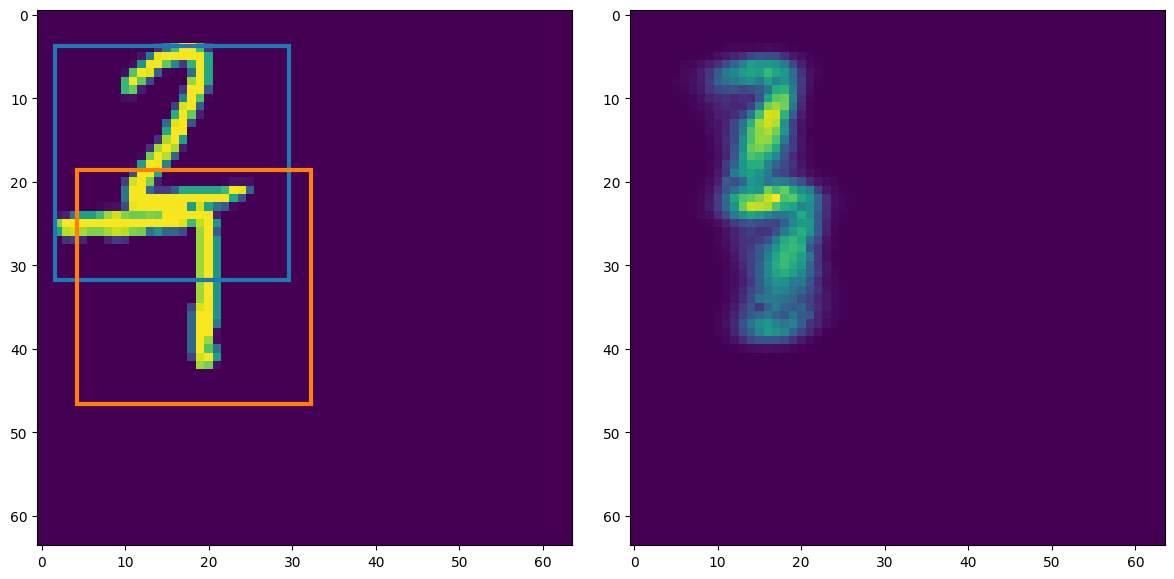

2024-07-25 14:04:52.794191: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [7]:
tf.config.experimental.set_visible_devices([], "GPU")  # Disable GPU for TF.
numpyro.set_platform(args.device)
main(args)

In [13]:
train_ds = load_dataset(is_training=True, batch_size=args.batch_size)

In [23]:
foo = next(train_ds)